## null for pcs
some concern that pcs are a biased estimator. Do we find pcQTL signals even with non-signal data?

keep the same clusters, just shuffle the expression values for each gene
run pcqtl on that and see if we get any eQTL or pcQTL signals. 

I find that a similar (small) proportion of pcqtl and eqtl phenotypes have a false positive signal

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

import tensorqtl
from tensorqtl import pgen, cis, trans, post, genotypeio

from upsetplot import from_memberships,  plot
from tqdm.auto import tqdm  # for notebooks

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from get_pcs import *

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
tissue_id = 'Skin_Not_Sun_Exposed_Suprapubic'



In [ ]:
# PLINK reader for genotypes
plink_prefix_path = '/home/klawren/oak/pcqtls/data/processed/genotypes/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.SHAPEIT2_phased.MAF01'

pgr = genotypeio.PlinkReader(plink_prefix_path)
genotype_df = pgr.load_genotypes()
variant_df = pgr.bim.set_index('snp')[['chrom', 'pos']]

In [2]:
# load in genotype data
covariates_file = f'/home/klawren/oak/pcqtls/data/processed/covariates_peers/{tissue_id}.v8.covariates.txt'
expression_path = f'/home/klawren/oak/pcqtls/output/proteincoding_main/clusters_expression/{tissue_id}.v8.normalized_residualized_expression.cluster_genes.bed'
cluster_df = pd.read_csv(f'/home/klawren/oak/pcqtls/output/proteincoding_main/clusters/{tissue_id}_clusters_all_chr.csv', index_col=0)
expression_df = pd.read_csv(expression_path, sep='\t')


# get the pcs
pc_path = f'/home/klawren/oak/pcqtls/output/proteincoding_main/pcs/{tissue_id}.pcs.bed'
pc_phenotype_df, pc_phenotype_pos_df = tensorqtl.read_phenotype_bed(pc_path)

# load phenotypes and covariates
phenotype_df, phenotype_pos_df = tensorqtl.read_phenotype_bed(expression_path)
covariates_df = pd.read_csv(covariates_file, sep='\t', index_col=0).T

In [131]:
# create shuffled expression and pcs
reordered = []
for idx, row in phenotype_df.iterrows():
    reordered.append(row.sample(frac=1).set_axis(phenotype_df.columns))
shuffled_e_phenotype_df = pd.DataFrame(reordered)

# get shuffled expression to right format
shuff_e_expression_df = pd.merge(phenotype_pos_df, shuffled_e_phenotype_df, left_on='gene_id', right_index=True).reset_index()
shuff_e_expression_df.rename(columns={'chr':'#chr'}, inplace=True)

# get pcs from shuffled expression
shuff_pc_expression_df = get_pc_bed(cluster_df, shuff_e_expression_df, covariates_df)
shuff_pc_phenotype_df = shuff_pc_expression_df[shuff_pc_expression_df.columns[3:]].set_index('gene_id')


Dropped 0 rows due to inf


In [159]:
# chr_list = ['chr21', 'chr22']
# susie finemapping for origonal expression
# orig_e_susie_summary, orig_e_susie_res = tensorqtl.susie.map(genotype_df, variant_df, 
#                         phenotype_df.loc[phenotype_pos_df['chr'].isin(chr_list)], 
#                         phenotype_pos_df.loc[phenotype_pos_df['chr'].isin(chr_list)],
#                         covariates_df, 
#                         summary_only=False)

# orig_pc_susie_summary, orig_pc_susie_res = tensorqtl.susie.map(genotype_df, variant_df, 
#                         pc_phenotype_df.loc[pc_phenotype_pos_df['chr'].isin(chr_list)], 
#                         pc_phenotype_pos_df.loc[pc_phenotype_pos_df['chr'].isin(chr_list)],
#                         covariates_df, 
#                         summary_only=False)

shuff_e_susie_summary, shuff_e_susie_res = tensorqtl.susie.map(genotype_df, variant_df, 
                        shuffled_e_phenotype_df, 
                        phenotype_pos_df,
                        covariates_df, 
                        summary_only=False)


shuff_pc_susie_summary, shuff_pc_susie_res = tensorqtl.susie.map(genotype_df, variant_df, 
                        shuff_pc_phenotype_df, 
                        pc_phenotype_pos_df,
                        covariates_df, 
                        summary_only=False)
    

SuSiE fine-mapping
  * 517 samples
  * 1860 phenotypes
  * 68 covariates
  * 10770860 variants
  * cis-window: ±1,000,000
  * checking phenotypes: 1860/1860
  * fine-mapping
    processing phenotype 1860/1860
  Time elapsed: 18.67 min
done.
SuSiE fine-mapping
  * 517 samples
  * 1860 phenotypes
  * 68 covariates
  * 10770860 variants
  * cis-window: ±1,000,000
  * checking phenotypes: 1860/1860
  * fine-mapping
    processing phenotype 1860/1860
  Time elapsed: 18.84 min
done.


In [162]:
orig_e_susie_summary = pd.read_csv(f'/home/klawren/oak/pcqtls/output/proteincoding_main/control_eqtl/{tissue_id}/{tissue_id}.v8.cluster_genes.susie.txt', sep='\t', index_col=0)
orig_pc_susie_summary = pd.read_csv(f'/home/klawren/oak/pcqtls/output/proteincoding_main/pcqtl/{tissue_id}/{tissue_id}.v8.pcs.susie.txt', sep='\t', index_col=0)

In [160]:
shuff_pc_susie_summary

,phenotype_id,variant_id,pip,af,cs_id
0,ENSG00000188984.11_ENSG00000204518.2_pc2,chr1_13546646_G_C_b38,0.908929,0.046422,1
1,ENSG00000188984.11_ENSG00000204518.2_pc2,chr1_13570786_C_T_b38,0.048330,0.041586,1
2,ENSG00000162365.11_ENSG00000186160.4_ENSG00000...,chr1_47763723_C_T_b38,0.016884,0.099613,1
3,ENSG00000162365.11_ENSG00000186160.4_ENSG00000...,chr1_47767441_C_T_b38,0.947855,0.091876,1
4,ENSG00000141086.17_ENSG00000205220.11_pc1,chr16_68525634_C_A_b38,0.001920,0.564797,1
...,...,...,...,...,...
3193,ENSG00000204983.13_ENSG00000275896.5_pc2,chr7_142435530_A_G_b38,0.003941,0.326886,1
3194,ENSG00000204983.13_ENSG00000275896.5_pc2,chr7_142437633_T_A_b38,0.008009,0.315280,1
3195,ENSG00000204983.13_ENSG00000275896.5_pc2,chr7_142438036_C_T_b38,0.008009,0.315280,1
3196,ENSG00000204983.13_ENSG00000275896.5_pc2,chr7_142439032_C_T_b38,0.053344,0.315280,1


In [161]:
shuff_e_susie_summary

,phenotype_id,variant_id,pip,af,cs_id
0,ENSG00000162365.11_ENSG00000186160.4_ENSG00000...,chr1_47757776_C_T_b38,0.017983,0.096712,1
1,ENSG00000162365.11_ENSG00000186160.4_ENSG00000...,chr1_47761267_A_T_b38,0.011584,0.088008,1
2,ENSG00000162365.11_ENSG00000186160.4_ENSG00000...,chr1_47763723_C_T_b38,0.019529,0.099613,1
3,ENSG00000162365.11_ENSG00000186160.4_ENSG00000...,chr1_47767441_C_T_b38,0.887474,0.091876,1
4,ENSG00000162365.11_ENSG00000186160.4_ENSG00000...,chr1_47775389_G_A_b38,0.014010,0.067698,1
...,...,...,...,...,...
2818,ENSG00000198074.9_ENSG00000227471.8_e_ENSG0000...,chr7_135270099_G_T_b38,0.019643,0.506770,1
2819,ENSG00000198074.9_ENSG00000227471.8_e_ENSG0000...,chr7_135270746_A_G_b38,0.012250,0.505803,1
2820,ENSG00000198074.9_ENSG00000227471.8_e_ENSG0000...,chr7_135273190_G_T_b38,0.002740,0.448743,1
2821,ENSG00000198074.9_ENSG00000227471.8_e_ENSG0000...,chr7_135280976_C_T_b38,0.014074,0.388781,1


In [177]:
# compare results
def get_num_cs(susie_summary):
    try:
        return len(susie_summary.groupby(['phenotype_id', 'cs_id']).nunique())
    except AttributeError:
        return 0
    
def get_frac_with_signal(susie_summary, total_signals = len(phenotype_df)):
    return susie_summary['phenotype_id'].nunique()/total_signals

In [178]:

cs_counts = pd.DataFrame({'shuffled':['shuffled', 'shuffled', 'original', 'original'], 
              'type':['eqtl', 'pcqtl', 'eqtl', 'pcqtl'], 
              'num_cs':[get_num_cs(shuff_e_susie_summary), get_num_cs(shuff_pc_susie_summary), get_num_cs(orig_e_susie_summary), get_num_cs(orig_pc_susie_summary)],
              'frac_signal':[get_frac_with_signal(shuff_e_susie_summary), get_frac_with_signal(shuff_pc_susie_summary), get_frac_with_signal(orig_e_susie_summary), get_frac_with_signal(orig_pc_susie_summary)]})


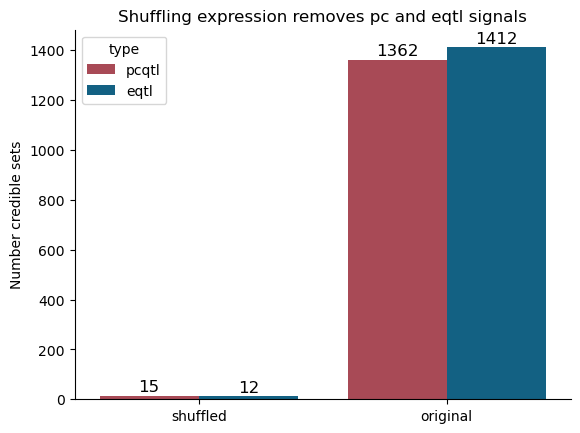

In [184]:
ax = sns.barplot(cs_counts, y='num_cs', x='shuffled', hue='type', hue_order=['pcqtl','eqtl'], palette=('#B83A4B', '#016895'))
ax.set_ylabel('Number credible sets')
ax.set_xlabel('')
ax.set_title('Shuffling expression removes pc and eqtl signals')

# Label each bar with its height
for p in ax.patches:
    if p.get_height() != 0:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', 
                    fontsize=12, color='black', 
                    xytext=(0, 1),  # offset text by 5 points in y-direction
                    textcoords='offset points')
        
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


In [3]:
# cs_counts = pd.DataFrame({'shuffled':['shuffled', 'shuffled', 'original', 'original'], 
#               'type':['eqtl', 'pcqtl', 'eqtl', 'pcqtl'], 
#               'num_cs':[12,15,1412,1362],
#               'frac_signal':[.006, .008, .535, .509]})

Z-statistic: -0.7315564195559534
P-value: 0.4644393562915041
Z-statistic: 1.5873241450992206
P-value: 0.11243924945100825


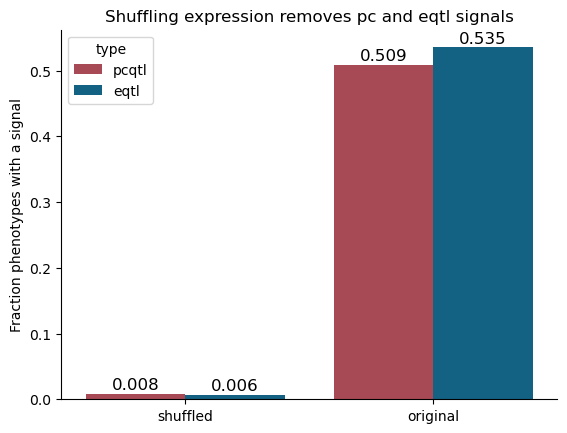

In [185]:
# this could also be as fraction phenotypes with a signal
ax = sns.barplot(cs_counts, y='frac_signal', x='shuffled', hue='type', hue_order=['pcqtl','eqtl'], palette=('#B83A4B', '#016895'))
ax.set_ylabel('Fraction phenotypes with a signal')
ax.set_xlabel('')
ax.set_title('Shuffling expression removes pc and eqtl signals')

# Label each bar with its height
for p in ax.patches:
    if p.get_height() != 0:
        ax.annotate(format(p.get_height(), '.3f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', 
                    fontsize=12, color='black', 
                    xytext=(0, 1),  # offset text by 5 points in y-direction
                    textcoords='offset points')
        
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [14]:

z_stat, p_value = proportions_ztest(cs_counts[cs_counts['shuffled']=='shuffled']['frac_signal'] * len(phenotype_df), [len(phenotype_df), len(phenotype_df)])

# Output the results
print("for the shuffled ones")
print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")

z_stat, p_value = proportions_ztest(cs_counts[cs_counts['shuffled']=='original']['frac_signal'] * len(phenotype_df), [len(phenotype_df), len(phenotype_df)])

# Output the results
print("for the original ones")
print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")


for the shuffled ones
Z-statistic: -0.7315564195559534
P-value: 0.4644393562915041
for the original ones
Z-statistic: 1.5873241450992206
P-value: 0.11243924945100825


In [199]:
shuff_pc_susie_summary['cluster_size'] = shuff_pc_susie_summary['phenotype_id'].str.split('_').apply(len)
shuff_pc_susie_summary['pc_num'] = shuff_pc_susie_summary['phenotype_id'].str.split('_pc').str[1].astype(int)

<AxesSubplot: xlabel='cluster_size', ylabel='count'>

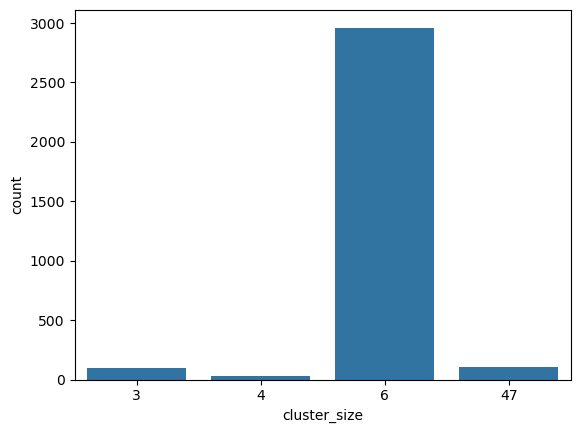

In [200]:
sns.countplot(shuff_pc_susie_summary, x='cluster_size')

<AxesSubplot: xlabel='pc_num', ylabel='count'>

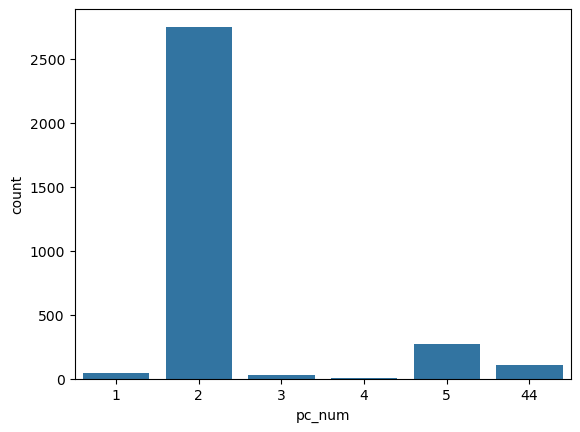

In [202]:
sns.countplot(shuff_pc_susie_summary, x='pc_num')